In [1]:
import os.path
import glob
import csv
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import dask.dataframe as dd
from dask.distributed import Client
from dask.distributed import get_worker
from fabric import Connection, Config

In [5]:
client = Client("tcp://128.110.217.26:8786")

In [6]:
client

<Client: 'tcp://128.110.217.26:8786' processes=2 threads=32, memory=125.38 GiB>

In [7]:
def create_metadata():
    mnist_data_path = "/users/prsridha/data/trainingSet/trainingSet/"
    mnist_metadata_out_path = "/users/prsridha/data/metadata.csv"
    data_rows = []
    num_labels = 10
    for i in range(num_labels):
        curr_label_path = mnist_data_path + str(i) + "/"
        jpgFilenamesList =  glob.glob(curr_label_path + '*.jpg')
        rows = [[str(fname), i] for fname in jpgFilenamesList]
        data_rows.extend(rows)
        # print(curr_label_path, str(len(jpgFilenamesList)))
    with open(mnist_metadata_out_path, 'w') as f: 
        write = csv.writer(f)
        write.writerows(data_rows)

In [8]:
create_metadata()

In [9]:
DATA_URL = "/users/prsridha/data/metadata.csv"
feature_names = ["image_path", "label"]
dtypes = {'image_path': str, 'label': np.int16}
df0 = pd.read_csv(DATA_URL, names=feature_names, dtype=dtypes)
df0 = dd.from_pandas(df0, npartitions=2)
df = df0.sample(frac=0.1)

In [9]:
df.head()

,image_path,label
7372,/users/prsridha/data/trainingSet/trainingSet/1...,1
1155,/users/prsridha/data/trainingSet/trainingSet/0...,0
539,/users/prsridha/data/trainingSet/trainingSet/0...,0
3689,/users/prsridha/data/trainingSet/trainingSet/0...,0
19954,/users/prsridha/data/trainingSet/trainingSet/4...,4


In [11]:
shuffled_df = df.sample(frac=1)
shuffled_df.head()

,image_path,label
18665,/users/prsridha/data/trainingSet/trainingSet/4...,4
16605,/users/prsridha/data/trainingSet/trainingSet/3...,3
949,/users/prsridha/data/trainingSet/trainingSet/0...,0
11451,/users/prsridha/data/trainingSet/trainingSet/2...,2
14742,/users/prsridha/data/trainingSet/trainingSet/3...,3


In [12]:
new_df = shuffled_df.repartition(npartitions=2)

In [13]:
user = "prsridha"
host = "128.110.217.26"
pem_path = "./cloudlab.pem"
connect_kwargs = {"key_filename":pem_path}
conn = Connection(host, user=user, connect_kwargs=connect_kwargs)

In [14]:
def pull(from_path, to_path, conn):
    to_path_dir = "/".join(to_path.split("/")[:-1])
    Path(to_path_dir).mkdir(parents=True, exist_ok=True)
    
    result = conn.get(from_path, to_path)
    print("Pulled from {0.remote} to {0.local}".format(result))

In [15]:
def resize_image(path, conn):
    if not os.path.isfile(path):
        pull(path, path, conn)
    
    im = Image.open(path)
    resized = im.resize((56,56))
    resized_np = np.array(resized)
    return resized_np

In [16]:
new_col = new_df.image_path.map_partitions(lambda x: x.apply(lambda y: resize_image(y, conn)), meta=('new_col', object))

In [17]:
new_col.compute()

18665    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
16605    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
949      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
11451    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
14742    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                               ...                        
34158    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
21881    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
38712    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
26165    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
22555    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: new_col, Length: 4200, dtype: object

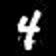

In [18]:
x = list(new_col.iteritems())[0]
im = Image.fromarray(x[1])
im.show()

In [19]:
y = list(new_df.image_path.iteritems())[0]
im1 = Image.open(y[1])
im1.show()

In [20]:
conn.close()